# 提取因子的封装函数

In [74]:
# 提取因子数据

#参数及工具函数部分
import pandas as pd
import numpy as np
from jqfactor import *
import warnings  
warnings.filterwarnings('ignore')

#获取数据主函数
#输入股票池、指标名称、开始日期、结束日期
#返回行标签为日期，列表签为股票名称的dataframe表格
def get_factor_data(stockPool, factor,date_start, date_end):
    
    #获取股票池函数
    def get_stock(stockPool, begin_date):
        if stockPool == 'HS300':#用于获取沪深300股票池
            stockList = get_index_stocks('000300.XSHG', begin_date)
        elif stockPool == 'ZZ500':#用于获取中证500股票池
            stockList = get_index_stocks('399905.XSHE', begin_date)
        elif stockPool == 'ZZ800':#用于获取中证800股票池
            stockList = get_index_stocks('399906.XSHE', begin_date)   
        elif stockPool == 'A':#用于获取全部A股股票池
            stockList = get_index_stocks('000002.XSHG', begin_date) + get_index_stocks('399107.XSHE', begin_date)
        else:#自定义输入股票池
            stockList = stockPool
        return stockList    
    
    #从财务库获取数据
    def get_factor_account_data(factor,stock, date):
        if factor in val:
            q = query(valuation).filter(valuation.code.in_(stock))
            df = get_fundamentals(q, date)
        elif factor in bal:
            q = query(balance).filter(balance.code.in_(stock))
            df = get_fundamentals(q, date)
        elif factor in cf:
            q = query(cash_flow).filter(cash_flow.code.in_(stock))
            df = get_fundamentals(q, date)
        elif factor in inc:
            q = query(income).filter(income.code.in_(stock))
            df = get_fundamentals(q, date)
        elif factor in ind:
            q = query(indicator).filter(indicator.code.in_(stock))
            df = get_fundamentals(q, date)

        df.index = df['code']
        data = pd.DataFrame(index = df.index)
        data[date] = df[factor]

        return data
    
    def get_trade_days(start_date = date_start, end_date = date_end):
    
        pool = get_index_stocks('000016.XSHG')

        date_list = get_price(pool,start_date=date_start,end_date=date_end,fields=['close'])['close'].index
        return date_list
    
    
    #获取日期列表
    date_list = get_trade_days(start_date = date_start, end_date = date_end)
    #空df预备存储数据，data_ret是返回数据
    data_ret = pd.DataFrame(data = [], columns = ['date','asset','factor'])
    
    #获取五张财务基础所有指标名称
    val = get_fundamentals(query(valuation).limit(1)).columns.tolist()
    bal = get_fundamentals(query(balance).limit(1)).columns.tolist()
    cf = get_fundamentals(query(cash_flow).limit(1)).columns.tolist()
    inc = get_fundamentals(query(income).limit(1)).columns.tolist()
    ind = get_fundamentals(query(indicator).limit(1)).columns.tolist()
    all_columns = val+bal+cf+inc+ind
    
    
    # 判断相应的股票池
    # 如果stockpool是字母，则按照字母提取
    # 如果stockpool是数组，则直接赋值字母
    # 确定相应的股票池
    if isinstance(stockPool,list):
        all_stocks = stockPool
    else:
        all_stocks = get_stock(stockPool, date_end)

    #循环时间列表获取指标数据
    for date in date_list:
        
        data_temp = pd.DataFrame(data = [],columns = ['date','asset','factor'])

        #获取股票池
        #获取因子数据
        if factor in all_columns: #可以从财务库直接取到因子值的因子
            data_temp['factor'] = get_factor_account_data(factor,all_stocks, date).iloc[:,0]
        
        
        # 改造成alphalen需要格式
        # 确定资产名称
        data_temp['asset'] =  get_factor_account_data(factor,all_stocks, date).index
        
        # 确定日期
        data_temp['date'] =  np.array([date for i in range(0,data_temp.shape[0])])
        
        
        # 删除原先的索引
        data_temp = data_temp.reset_index()
        data_temp = data_temp.drop(['code'],axis=1)
        
        data_ret = pd.concat([data_ret, data_temp], axis = 0) 
        

        # 如果不需要则进行正常的数据合并
        #         data = pd.concat([data, data_temp], axis = 0) 

    # 确定 multi_index
    data_ret = data_ret.set_index(['date','asset'])
    return data_ret



# 去极值、中性化、标准化的封装函数

In [75]:
from sklearn.linear_model import LinearRegression

def mad(factor):
    # 3倍中位数去极值
    # 确定输入变量
    factor = np.array(factor)
        
    # 求出因子值的中位数
    med = np.median(factor)

    # 求出因子值与中位数的差值，进行绝对值
    mad = np.median(abs(factor - med))

    # 定义几倍的中位数上下限
    high = med + (3 * 1.4826 * mad)
    low = med - (3 * 1.4826 * mad)

    # 替换上下限以外的值
    factor = np.where(factor > high, high, factor)
    factor = np.where(factor < low, low, factor)
    
    # 因为np处理后会将数据由[x]变为[[x]]的数据，所以进行处理
    ret = factor
    return ret


def stand(factor):
    factor = np.array(factor)
    mean = factor.mean()
    std = factor.std()
    return (factor - mean)/std
    
# factor1：主参数，一般为需要被中性化的参数
# factor2：被动参数，一般作为参考想象，一般是市值作为中性化的参考参数
def neutral(factor1,factor2):
    # 统一类型
    factor1 = np.array(factor1)
    factor2 = np.array(factor2)
    
    # 去除0值
    factor1[np.isnan(factor1)] = 0
    factor2[np.isnan(factor2)] = 0

    
    # 根据LinearRegression的要求需要将参数做reshape的处理
    # python 3 在这里有一错误，所以要增加values的设置
    # x = factor2.values.reshape(-1,1)
    # y = factor1.values.reshape(-1,1)
    
    # 注意：以下代码为np的reshape（pandas的reshape与np的reshape略有不同）
    x = np.reshape(factor2,(-1,1))
    y = np.reshape(factor1,(-1,1))
    try:
        # 建立回归方程并预测
        lr = LinearRegression()
        lr.fit(x, y)
        y_predict = lr.predict(x)
    except:
        print("出错，未进行中性化")
        # 如果出错，则预测值统一列为0，保持原值
        y_predict = 0
        
    # 去除线性的关系，留下误差作为该因子的值
    res = y - y_predict   
    
    # 因为np处理后会将数据由[x]变为[[x]]的数据，所以进行处理
    return [d[0] for d in res]

# 在上面Neutral函数的基础上，对原始数据中性化

- 逐日期进行，对每个截断面数据进行操作
- 每个日期按照去极值、市值中性化、标准化的流程进行

In [76]:
from datetime import datetime

from sklearn.linear_model import LinearRegression


def neutral_data_by_market_cap(factor_input,if_market_neutral):
    
    factor_data = factor_input
    
    # 遍历每一个日期
    for date_i in set([index[0] for index, row in factor_data.iterrows()]):
    # for date_i in [datetime.strptime('2016-01-11', '%Y-%m-%d')]:

        # print(date_i)
        # 临时赋值使用的factor_temp_pd
        factor_temp_np = pd.DataFrame()
        factor_refer = pd.DataFrame()


        # 提取每一个日期的股票编码列表
        sec_list = []
        sec_list = list(factor_data.loc[(date_i)].index)

        factor_temp_np = np.array(factor_data.loc[(date_i),'factor'])

        # 去极值
        factor_temp_np = mad(factor_temp_np)

        # 如果需要市值中性化，则进行中性化
        if if_market_neutral:
            # 中性化 
            # 提取参考的市值因子
            factor_refer = get_factor_data(sec_list,'market_cap',date_i,date_i)
            factor_refer = factor_refer.loc[(date_i),'factor']
            
            factor_temp_np = neutral(factor_temp_np,factor_refer)
            # 标准化
            factor_temp_np = stand(factor_temp_np)
        # 不需要市值中性化的话
        else:
            factor_temp_np = stand(factor_temp_np)
        
        # 赋值
        factor_data.loc[(date_i),'factor'] = np.array(factor_temp_np)
        
    return factor_data

In [77]:
# IC分析
from alphalens.tears import create_information_tear_sheet
from alphalens.utils import get_clean_factor_and_forward_returns

# alphalen数据清理
from alphalens.utils import get_clean_factor_and_forward_returns


# 关闭告警
import warnings
warnings.filterwarnings("ignore")

# 设置因子池、倒置控制数组
factor_pool = ['pb_ratio','inc_return','market_cap']
if_reverse = [1,0,1]

# 设置起始、终止日期
begin_date = '2018-10-10'
end_date = '2019-10-20'


factor_total_pd = pd.DataFrame()


# 开始财务因子循环
for i in range(0,len(factor_pool)):
# for i in range(0,1):

    # 因子赋值
    factor_i = factor_pool[i]
    if_reverse_i = if_reverse[i]
    
    print("$$处理因子值：%s"%str(factor_i))
    
    
    # 提取因子
    # 示例，获取沪深300成分股在2019年前两个月的市盈率数据
    # 注意：每次只能提取1个因子
    factor_data = get_factor_data('HS300', factor_i,begin_date, end_date)
    factor_data = factor_data.fillna(0)
    
    # 确定是否取倒数
    if if_reverse_i:
        factor_data['factor'] = 1/factor_data['factor']
        print("--取倒数")
    print("--提取因子完成")

        
    # 去极值、中性化、标准化
    # 第二个参数“1”/“0”表示 需要/不需要 进行市值中性化
    factor_data = neutral_data_by_market_cap(factor_data,0)
    
    print("--数据中性化完成")

    # 数据合并
    # 更改列名
    factor_data.rename(columns={'factor':factor_i}, inplace = True)
    
    factor_total_pd = pd.concat([factor_total_pd,factor_data],axis = 1)
    print("--数据合并完成")



$$处理因子值：pb_ratio
--取倒数
--提取因子完成
--数据中性化完成
--数据合并完成
$$处理因子值：inc_return
--提取因子完成
--数据中性化完成
--数据合并完成
$$处理因子值：market_cap
--取倒数
--提取因子完成
--数据中性化完成
--数据合并完成


# 获取技术因子，并进行中性化等操作


In [67]:
# 设置因子池、倒置控制数组
factor_pool = ['EMAC10','EMA5']
if_reverse = [0,0]

# 设置起始、终止日期
# 与上面的日期一直

factor_total_tec_pd = pd.DataFrame()

# 开始财务因子循环
for i in range(0,len(factor_pool)):
# for i in range(0,1):

    # 因子赋值
    factor_i = factor_pool[i]
    if_reverse_i = if_reverse[i]
    
    print("$$处理因子值：%s"%str(factor_i))
    
    
    # 提取因子
    # 示例，获取沪深300成分股在2019年前两个月的市盈率数据
    # 注意：每次只能提取1个因子
    stock_pool = get_index_stocks('000300.XSHG', end_date)
    
    
    factor_data_tec = pd.DataFrame()
    factor_data_factor_raw = get_factor_values(stock_pool, [factor_i], start_date =begin_date, end_date = end_date)[factor_i]
    for row_i in range(0,factor_data_factor_raw.shape[0]):
     
        # 初始化清零
        factor_data_temp = pd.DataFrame()
        
        # 关键函数赋值
        factor_data_temp['factor']  = factor_data_factor_raw.iloc[row_i,:].T
        factor_data_temp['date']  = np.array([factor_data_factor_raw.index[row_i] for i in range(0,factor_data_factor_raw.shape[1])])
        factor_data_temp['asset']  = factor_data_temp.index
        
        # 删除index
        factor_data_temp = factor_data_temp.reset_index()
        factor_data_temp = factor_data_temp.drop(['code'],axis=1)
        
        # 如果不需要则进行正常的数据合并
        factor_data_tec = pd.concat([factor_data_tec, factor_data_temp], axis = 0) 
        
    
    # 确定 multi_index
    factor_data_tec = factor_data_tec.set_index(['date','asset'])

    # 确定是否取倒数
    if if_reverse_i:
        factor_data_tec['factor'] = 1/factor_data_tec['factor']
        print("--取倒数")
    print("--提取因子完成")

    factor_data_tec = factor_data_tec.fillna(1)
    # 去极值、中性化、标准化
    # 第二个参数“1”/“0”表示 需要/不需要 进行市值中性化
    factor_data_tec = neutral_data_by_market_cap(factor_data_tec,0)
    
    print("--数据中性化完成")

    
    # 数据合并
    # 更改列名
    factor_data_tec.rename(columns={'factor':factor_i}, inplace = True)
    
    factor_total_tec_pd = pd.concat([factor_total_tec_pd,factor_data_tec],axis = 1)
    factor_total_tec_pd = factor_total_tec_pd.fillna(1)
    
    print("--数据合并完成")


$$处理因子值：EMAC10
--提取因子完成
--数据中性化完成
--数据合并完成
$$处理因子值：EMA5
--提取因子完成
--数据中性化完成
--数据合并完成


In [68]:
factor_total_tec_pd

EMAC10      EMA5
date       asset                          
2018-10-10 000001.XSHE -0.481243 -0.110799
           000002.XSHE  1.875149  1.811193
           000063.XSHE  1.300509  0.948119
           000069.XSHE  0.513806  0.728108
           000100.XSHE -0.121000 -0.163697
           000157.XSHE -0.160438 -0.335116
           000166.XSHE -0.085992 -0.247575
           000333.XSHE  0.436275  0.320802
           000338.XSHE -1.208651 -1.000097
           000402.XSHE  0.318593  0.336999
           000408.XSHE  0.192408  0.466833
           000413.XSHE  0.083508 -0.010274
           000415.XSHE -0.526812 -0.061951
           000423.XSHE -0.128990  0.213079
           000425.XSHE -0.164394 -0.385507
           000538.XSHE  1.081326  0.603544
           000553.XSHE -0.527326 -0.510071
           000568.XSHE  1.979104  2.372909
           000596.XSHE  1.510674  2.372909
           000625.XSHE -0.556638 -0.490531
           000627.XSHE  0.047749 -0.053402
           000629.XSHE -2.536523 -0.492138
           000630.XSHE -0.982821 -1.039883
           000651.XSHE -0.384210 -0.071528
           000656.XSHE  0.671953  0.248301
           000661.XSHE -0.130691  0.105162
           000671.XSHE  0.759651  0.620384
           000703.XSHE -0.165185  0.017107
           000709.XSHE -0.670996 -0.433456
           000725.XSHE  0.655260  0.323695
...                          ...       ...
2019-10-18 601828.XSHG  0.513997  0.589018
           601838.XSHG -0.523082 -0.227501
           601857.XSHG -0.129247 -0.363588
           601877.XSHG  0.405465  0.386111
           601878.XSHG  0.456066  0.808123
           601881.XSHG  0.864891  0.877474
           601888.XSHG -0.687841 -0.729495
           601898.XSHG  0.399317  0.378687
           601899.XSHG  0.715123  0.584209
           601901.XSHG  0.547904  0.556114
           601919.XSHG  1.213705  1.597644
           601933.XSHG -0.029654 -0.089053
           601939.XSHG -0.832408 -0.833352
           601985.XSHG  0.121581  0.013455
           601988.XSHG -0.702832 -0.750334
           601989.XSHG  0.768939  0.605385
           601992.XSHG  0.110420  0.671952
           601997.XSHG  0.059300  0.589018
           601998.XSHG -1.010362 -0.836727
           603019.XSHG  0.615056  0.316929
           603156.XSHG  0.034519 -0.190126
           603160.XSHG  0.765865  0.493766
           603259.XSHG -1.065077 -0.898822
           603260.XSHG  0.567860  0.216193
           603288.XSHG  0.247704  0.203031
           603799.XSHG  1.770644  0.930964
           603833.XSHG -1.316331 -1.586595
           603858.XSHG -0.508658 -0.389658
           603986.XSHG  2.531841  2.420161
           603993.XSHG  0.682067  0.538819

[75000 rows x 2 columns]

# 财务因子与技术因子合并

In [78]:
factor_total_pd = pd.concat([factor_total_pd,factor_data_tec],axis=1)
factor_total_pd


pb_ratio  inc_return  market_cap      EMA5
date       asset                                                  
2018-10-10 000001.XSHE  1.638084   -0.109960   -1.286210 -0.110799
           000002.XSHE -0.110124    1.073461   -1.389649  1.811193
           000063.XSHE -0.691249   -2.866352   -0.655866  0.948119
           000069.XSHE  1.374348   -0.755115   -0.190858  0.728108
           000100.XSHE  0.678124   -0.659678    0.297410 -0.163697
           000157.XSHE  1.921395   -0.881092    0.894122 -0.335116
           000166.XSHE  0.349286   -0.655860   -0.949733 -0.247575
           000333.XSHE -0.732038    2.317962   -1.421269  0.320802
           000338.XSHE -0.124927    1.000929   -0.613756 -1.000097
           000402.XSHE  2.548059   -0.892544    1.966793  0.336999
           000408.XSHE -0.730010    0.756610    1.445117  0.466833
           000413.XSHE  1.316778   -0.743663    0.764733 -0.010274
           000415.XSHE  2.308001   -0.422994    1.413498 -0.061951
           000423.XSHE -0.665961   -0.575693    0.778702  0.213079
           000425.XSHE  0.718776   -0.453534    0.746192 -0.385507
           000538.XSHE -0.870980    0.180169   -0.691277  0.603544
           000553.XSHE  0.436915   -0.663495    0.765281 -0.510071
           000568.XSHE -0.940958    0.943667   -0.493029  2.372909
           000596.XSHE -1.053749    0.424488    0.270099  2.372909
           000625.XSHE  2.164286   -1.415540    0.476863 -0.490531
           000627.XSHE  0.200663   -0.598598    0.757698 -0.053402
           000629.XSHE -1.138392    2.634980    0.345254 -0.492138
           000630.XSHE  0.576153   -0.850552    1.519974 -1.039883
           000651.XSHE -0.613676    2.634980   -1.376855 -0.071528
           000656.XSHE  0.164136   -0.312286    1.100297  0.248301
           000661.XSHE -1.209524    1.470480    0.220905  0.105162
           000671.XSHE  0.359552    0.260337    1.508636  0.620384
           000703.XSHE -0.602003   -0.266477    0.257039  0.017107
           000709.XSHE  2.336122   -0.125230    0.507370 -0.433456
           000725.XSHE  0.713939   -1.251388   -0.994316  0.323695
...                          ...         ...         ...       ...
2019-10-18 601828.XSHG  1.367984   -0.411015    0.297639  0.589018
           601838.XSHG  1.235551    0.375381    0.806058 -0.227501
           601857.XSHG  1.339098   -0.678815   -1.466706 -0.363588
           601877.XSHG -0.272273    1.047006    0.005211  0.386111
           601878.XSHG -0.269207   -0.653310    0.922905  0.808123
           601881.XSHG  0.123704   -0.593799   -0.870590  0.877474
           601888.XSHG -1.246101    0.834466   -1.148608 -0.729495
           601898.XSHG  2.354251   -0.257986   -0.409306  0.378687
           601899.XSHG -0.252913   -0.317498   -0.569402  0.584209
           601901.XSHG  0.264271   -1.048633   -0.255464  0.556114
           601919.XSHG -0.198968   -0.517285   -0.305085  1.597644
           601933.XSHG -0.900634   -0.912608   -0.696345 -0.089053
           601939.XSHG  1.297912    0.341375   -1.491577 -0.833352
           601985.XSHG -0.020862   -0.189974   -0.661028  0.013455
           601988.XSHG  2.258274    0.269111   -1.464824 -0.750334
           601989.XSHG  0.269629   -0.972119   -0.951222  0.605385
           601992.XSHG  1.654338    0.188346    0.404213  0.671952
           601997.XSHG  1.351406    0.337124    1.010832  0.589018
           601998.XSHG  2.269870   -0.117880   -1.289518 -0.836727
           603019.XSHG -1.183628   -0.423767    0.799369  0.316929
           603156.XSHG -0.534721   -0.508783    0.896189 -0.190126
           603160.XSHG -1.355152    2.340663   -0.720612  0.493766
           603259.XSHG -1.186670   -0.083704   -1.040399 -0.898822
           603260.XSHG -0.755395   -0.113460    1.036935  0.216193
           603288.XSHG -1.377495    2.232976   -1.285809  0.203031
           603799.XSHG -0.748353   -1.584233    1.220434  0.930964
           603833.XSHG -1.087815    1.582605   -0.080099 -1.586595
    

In [80]:

factor_total_pd['factor'] = 0

col_pool = factor_total_pd.columns[0:3]
col_pool
for col in col_pool:
    factor_total_pd['factor'] = factor_total_pd[col] + factor_total_pd['factor'] 

In [81]:
factor_total_pd

pb_ratio  inc_return    ...         EMA5    factor
date       asset                                ...                       
2018-10-10 000001.XSHE  1.638084   -0.109960    ...    -0.110799  0.241915
           000002.XSHE -0.110124    1.073461    ...     1.811193 -0.426313
           000063.XSHE -0.691249   -2.866352    ...     0.948119 -4.213467
           000069.XSHE  1.374348   -0.755115    ...     0.728108  0.428375
           000100.XSHE  0.678124   -0.659678    ...    -0.163697  0.315856
           000157.XSHE  1.921395   -0.881092    ...    -0.335116  1.934424
           000166.XSHE  0.349286   -0.655860    ...    -0.247575 -1.256308
           000333.XSHE -0.732038    2.317962    ...     0.320802  0.164655
           000338.XSHE -0.124927    1.000929    ...    -1.000097  0.262246
           000402.XSHE  2.548059   -0.892544    ...     0.336999  3.622307
           000408.XSHE -0.730010    0.756610    ...     0.466833  1.471716
           000413.XSHE  1.316778   -0.743663    ...    -0.010274  1.337848
           000415.XSHE  2.308001   -0.422994    ...    -0.061951  3.298505
           000423.XSHE -0.665961   -0.575693    ...     0.213079 -0.462952
           000425.XSHE  0.718776   -0.453534    ...    -0.385507  1.011435
           000538.XSHE -0.870980    0.180169    ...     0.603544 -1.382088
           000553.XSHE  0.436915   -0.663495    ...    -0.510071  0.538700
           000568.XSHE -0.940958    0.943667    ...     2.372909 -0.490319
           000596.XSHE -1.053749    0.424488    ...     2.372909 -0.359162
           000625.XSHE  2.164286   -1.415540    ...    -0.490531  1.225608
           000627.XSHE  0.200663   -0.598598    ...    -0.053402  0.359762
           000629.XSHE -1.138392    2.634980    ...    -0.492138  1.841842
           000630.XSHE  0.576153   -0.850552    ...    -1.039883  1.245576
           000651.XSHE -0.613676    2.634980    ...    -0.071528  0.644449
           000656.XSHE  0.164136   -0.312286    ...     0.248301  0.952147
           000661.XSHE -1.209524    1.470480    ...     0.105162  0.481861
           000671.XSHE  0.359552    0.260337    ...     0.620384  2.128525
           000703.XSHE -0.602003   -0.266477    ...     0.017107 -0.611440
           000709.XSHE  2.336122   -0.125230    ...    -0.433456  2.718262
           000725.XSHE  0.713939   -1.251388    ...     0.323695 -1.531765
...                          ...         ...    ...          ...       ...
2019-10-18 601828.XSHG  1.367984   -0.411015    ...     0.589018  1.254608
           601838.XSHG  1.235551    0.375381    ...    -0.227501  2.416990
           601857.XSHG  1.339098   -0.678815    ...    -0.363588 -0.806422
           601877.XSHG -0.272273    1.047006    ...     0.386111  0.779943
           601878.XSHG -0.269207   -0.653310    ...     0.808123  0.000389
           601881.XSHG  0.123704   -0.593799    ...     0.877474 -1.340684
           601888.XSHG -1.246101    0.834466    ...    -0.729495 -1.560243
           601898.XSHG  2.354251   -0.257986    ...     0.378687  1.686958
           601899.XSHG -0.252913   -0.317498    ...     0.584209 -1.139813
           601901.XSHG  0.264271   -1.048633    ...     0.556114 -1.039826
           601919.XSHG -0.198968   -0.517285    ...     1.597644 -1.021338
           601933.XSHG -0.900634   -0.912608    ...    -0.089053 -2.509586
           601939.XSHG  1.297912    0.341375    ...    -0.833352  0.147710
           601985.XSHG -0.020862   -0.189974    ...     0.013455 -0.871864
           601988.XSHG  2.258274    0.269111    ...    -0.750334  1.062562
           601989.XSHG  0.269629   -0.972119    ...     0.605385 -1.653712
           601992.XSHG  1.654338    0.188346    ...     0.671952  2.246897
           601997.XSHG  1.351406    0.337124    ...     0.589018  2.699362
           601998.XSHG  2.269870   -0.117880    ...    -0.836727  0.862472
           603019.XSHG -1.183628   -0.423767    ...     0.316929 -0.808026
           603156.XSHG -0.534721   -0.508783    .

Dropped 16.3% entries from factor data (16.3% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.
Information Analysis


,10,20,40
IC Mean,0.005,-0.009,-0.033
IC Std.,0.109,0.120,0.127
Risk-Adjusted IC,0.045,-0.073,-0.263
t-stat(IC),0.650,-1.054,-3.812
p-value(IC),0.517,0.293,0.000
IC Skew,0.328,0.291,-0.076
IC Kurtosis,-0.219,0.512,-0.847


<Figure size 432x288 with 0 Axes>

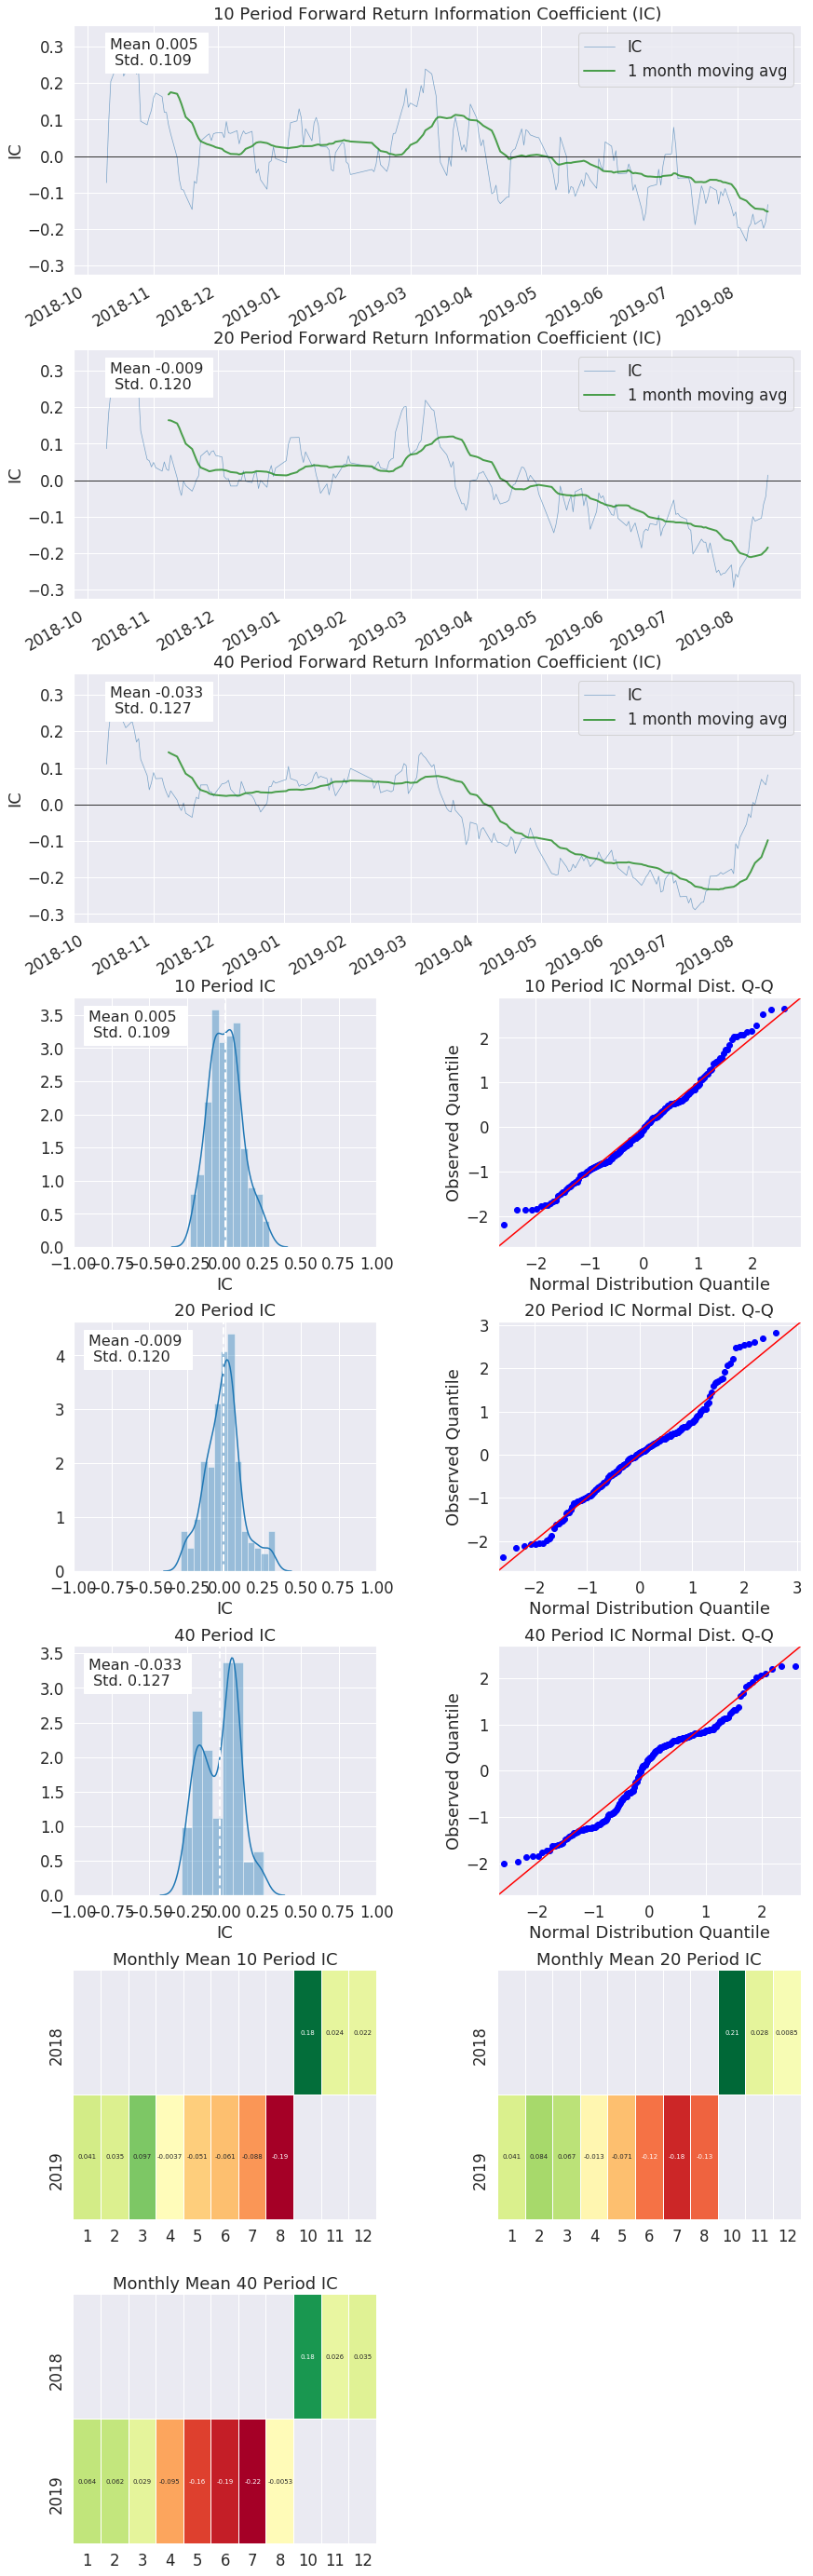

In [82]:
# 严格意义应在循环外处理
# 此处仅为示例
# 提取价格数据
all_stocks = list(set([index[1] for index, row in factor_data.iterrows()]))
price_data = get_price(all_stocks,start_date=begin_date , end_date = end_date,fields=['close'])['close']


# 数据清洗
merged_data = get_clean_factor_and_forward_returns(
  factor=factor_total_pd['factor'], 
  prices=price_data,
  periods = [10,20,40] 
)

create_information_tear_sheet(merged_data)

Returns Analysis


,10,20,40
Ann. alpha,0.016,-0.011,-0.037
beta,0.004,0.022,0.019
Mean Period Wise Return Top Quantile (bps),1.896,0.347,-1.148
Mean Period Wise Return Bottom Quantile (bps),0.635,1.598,3.079
Mean Period Wise Spread (bps),1.307,-1.229,-4.219


<Figure size 432x288 with 0 Axes>

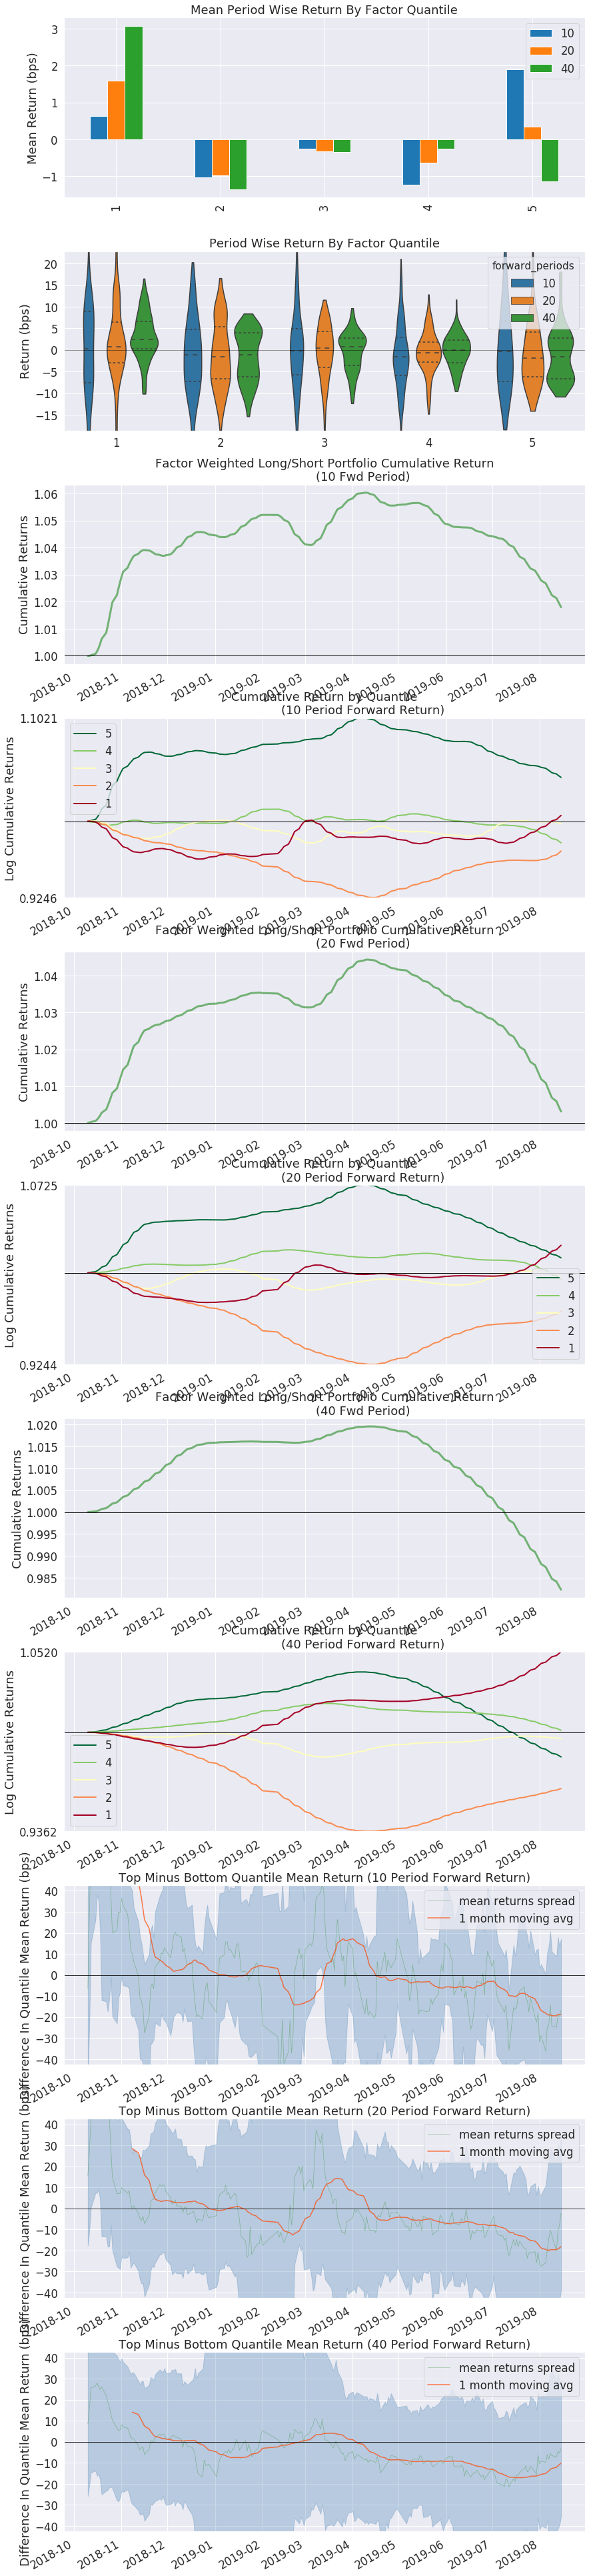

In [83]:
from alphalens.tears import create_returns_tear_sheet

create_returns_tear_sheet(factor_data=merged_data, by_group=False)
